#AmeniDC
## See the cost of amenities in the District of Columbia

In [27]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 4 * matplotlib.rcParams['savefig.dpi']
import matplotlib.pylab as plt

# Define amenity types of interest
AMENITY_TYPES = ['bakery','bar','cafe','grocery_or_supermarket',
  'movie_theater','park','pharmacy','restaurant','school','spa','subway_station']

In [173]:
import simplejson as json
import requests
from requests import Request, Session
from bs4 import BeautifulSoup
import re

from urlparse import urljoin
from collections import namedtuple
import sqlite3
from pyspark.sql import SQLContext

import numpy as np
import pandas as pd
import dill as pickle

import pprint
pp = pprint.PrettyPrinter(indent=0)

#OpenData.DC API

Get the property sale points from http://opendata.dc.gov/datasets/2acc75ccdd954267acecb8713b2b800a_28
and store as a SQL database pandas DataFrame

In [ ]:
from ediblepickle import checkpoint


@checkpoint(key='prop_sales_json.csv', work_dir='data', refresh=False)
def request_records():
  url = 'http://opendata.dc.gov/datasets/2acc75ccdd954267acecb8713b2b800a_28.geojson'
  with requests.Session() as s:
    resp = s.get(url)
    try:
        resp.raise_for_status()
    except requests.exceptions.HTTPError as e:
        print "And you get an HTTPError:", e.message
  return resp.json()
  
  
def build_df(resp_json):
  keep_cols = [u'ADDRESS1',u'ADDRESS2',u'ANNUALTAX',u'ASSESSMENT',
               u'BASEBUILD',u'BASELAND',u'CITYSTZIP',
               u'HIGHNUMBER',u'HSTDCODE',u'LANDAREA',u'LOT',
               u'LOWNUMBER',u'NBHD',
               u'NEWIMPR',u'NEWLAND',u'NEWTOTAL',
               u'OLDIMPR',u'OLDLAND',u'OLDTOTAL',u'OWNOCCT',
               u'PREMISEADD',u'PROPTYPE',u'QDRNTNAME',u'SALEDATE',
               u'SALEPRICE',u'SALETYPE',u'SQUARE',u'SSL',u'STREETCODE',u'STREETNAME',
               u'SUBNBHD',u'coordinates']
    
  row_dicts = []
  for feats in resp_json['features']:
    try:
      # get coordinates
      row = dict(zip(['longitude','latitude'],feats['geometry']['coordinates']))
    except:
      continue
    attrs = feats['properties'] # get select property attributes
    row.update(dict(( (k,attrs.get(k,'')) for k in keep_cols )))
    row_dicts.append(row)
    
  df = pd.DataFrame(row_dicts)
  print df.columns

  df['lat_lng'] = df.loc[:,('latitude','longitude')].apply(
      lambda row: str(row[0])+','+str(row[1]),axis=1)

  df.to_hdf('./data/df_cleaned_wo_amen.hd5','df')
  

if False:
  resp_json = request_records()
  print resp_json['features'][0]
if False:
  build_df(resp_json)

Only keep residential single family residences

In [ ]:
if False:
  df = pd.read_hdf('./data/df_cleaned_wo_amen.hd5','df')
  print df['PROPTYPE'].unique()
  df = df.loc[df['PROPTYPE']==u'RESIDENTIAL-SINGLE FAMILY',:].copy()
  print df['PROPTYPE'].unique()
  df.to_hdf('./data/df_cleaned_res_only.hd5','df')


Parse the zipcodes and remove zipcodes that aren't in DC

In [ ]:
from sklearn import cross_validation, grid_search, neighbors

def zip_parser(x):
  z = x.split()[-1][:5]
  try:
    zint = int(z)
    if len(z) == 5:
      return z
    else:
      return u''
  except:
    return u''
  
if False:
  df = pd.read_hdf('./data/df_cleaned_res_only.hd5','df')
  df['zipcode'] = df.CITYSTZIP.map(lambda r: zip_parser(r))

  #print df.zipcode.unique()

  # extract zips from CITYSTZIP column
  df['zipcode'] = df.CITYSTZIP.map(lambda r: zip_parser(r))
  

  # Use nearest neighbors to fill in missing
  param_grid = {"n_neighbors": range(4,10)}
  zip_model = grid_search.GridSearchCV( neighbors.KNeighborsClassifier(),
                  param_grid=param_grid,
                  cv=cross_validation.ShuffleSplit(len(df.index), n_iter=20, 
                      test_size=0.2,random_state=42) )

  zip_model.fit(df[['latitude','longitude']],df['zipcode'])
  for key in param_grid.keys():
    grid_score_plotter(zip_model,key)

  badzip = df.zipcode==''
  df.loc[badzip,'zipcode'] = zip_model.predict(df.loc[badzip,('latitude','longitude')])
  
  df.to_hdf('./data/df_cleaned_zipcodes.hd5','df')


# Google Maps Places API

Here, property sale locations are queried for nearby amenities. API requests were made once offline and pickled. Data for each lat_lng pair were stored as dict. 

Create a df column showing amenity_price_rating numbers for the top 20 hits within 1000m of the property

In [ ]:
if True:
  #df = pd.read_hdf('./data/df_cleaned_zipcodes.hd5','df')
  df = pd.read_hdf('./data/df_w_amen.hd5','df')


In [ ]:
if True:
  df = df.iloc[:15,:].copy()
  df.reset_index(inplace=True)

In [ ]:
len(df.columns)

In [ ]:
df['lat_lng'][0]

In [ ]:
import simplejson as json
import pandas as pd
from requests import Request, Sessio
from requests_futures.sessions import FuturesSession
from collections import namedtuple
import operator
import time


# Read in all API keys
with open("../secrets/google_secrets.json.nogit") as fh: 
  secrets = json.loads(fh.read())
google_api_key = secrets['server_api_key']

Summary = namedtuple('Summary',['count','count_rating','sum_rating','sum_rating_sq',
                               'count_price_level','sum_price_level','sum_price_level_sq'])

def google_places_parser(sess,resp):
  
  if False:
    print resp.json()['results'][0]
  
  count = 0
  count_rating = 0
  sum_rating = 0
  sum_rating_sq = 0
  count_price_level = 0
  sum_price_level = 0
  sum_price_level_sq = 0

  for r in resp.json()['results']:
    rating = r.get('rating')
    if rating:
      count_rating += 1
      sum_rating += float(rating)
      sum_rating_sq += float(rating)**2

    price_level = r.get('price_level')
    if price_level:
      count_price_level += 1
      sum_price_level += float(price_level)    
      sum_price_level_sq += float(price_level)**2    
    
    count += 1

  summary = Summary(count,count_rating,sum_rating,sum_rating_sq,
                   count_price_level,sum_price_level,sum_price_level_sq)

  resp.data = {'next_page_token':resp.json().get('next_page_token',''),
               'summary':summary}


def make_urls(npt_ll_series,amen_query):
  base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
  s = Session()
  
  urls = []
  for row in npt_ll_series:
    npt, ll = row
    if npt == '':
      search_payload = {"key":google_api_key,
                        "radius":1000,
                        "types":amen_query,
                        "location":ll}
    else:
      '''Including a page token forces Google to ignore all other
      search parameters'''
      search_payload = {"key":google_api_key,
                        'pagetoken':npt}

    req = Request('GET', base_url, params=search_payload)

    urls.append(s.prepare_request(req).url)
  
  return urls

In [ ]:
# Build up the dataframe
from itertools import izip

session = FuturesSession(max_workers=7)

start_time = time.time()
for k in range(10,4,-1):
  amenity = AMENITY_TYPES[k]
  df['next_page_token'] = ''
  df[amenity] = df.apply(lambda _: Summary(0,0,0,0,0,0,0),axis=1)kkkjjj
  get_more = df.index
  
  for i in xrange(3):
    urls = make_urls(df.ix[get_more,('next_page_token','lat_lng')].as_matrix(),amenity)    
    results = (session.get(url,background_callback=google_places_parser) 
               for url in urls)
    outputs = ((x.result().data['next_page_token'],x.result().data['summary']) 
               for x in results)

    npts,summaries = izip(*outputs)
    df.ix[get_more,amenity] = pd.Series((Summary(*map(operator.add,x[0],x[1]))
                                for x in izip(df.ix[get_more,amenity],summaries)),index=get_more)
    df.ix[get_more,"next_page_token"] = npts

    get_more = df.index[df.next_page_token != '']
    
    print i,len(get_more)
    if len(get_more) == 0:
      break
    time.sleep(2) # delay because next page is not immediately available
  
  if True:
    df.to_hdf('./data/df_w_amen.hd5','df')
    
print("--- %s seconds ---" % (time.time() - start_time))



### Find count and mean of each amenity ###

In [ ]:
AMENITY_TYPES

In [ ]:
if True:`
  df = pd.read_hdf('./data/df_w_amen.hd5','df')


In [ ]:
if True:
  df = df.sample(100).copy()


In [ ]:
len(df.index)

In [ ]:
for amenity in AMENITY_TYPES:
  sum_cols = ['count','count_rating','mean_rating','std_rating',
              'count_price_level','mean_price_level','std_price_level']
  df = pd.concat( [df,pd.DataFrame.from_records(
                      df[amenity].map(lambda x: summarizer(x)).tolist(),
                      columns=[amenity + '_' + s for s in sum_cols],
                      index=df.index)], axis = 1
            )

In [ ]:
if True:
  df.to_hdf('./data/df_w_amen_flat.hd5','df')

#Visualize the data

In [ ]:
valid_zipcodes = []
with open('./data/valid_zipcodes.txt','r') as f:
  valid_zipcodes = [line.strip() for line in f.readlines()]

In [51]:
if True:
  df = pd.read_hdf('./data/df_w_amen_flat.hd5','df')
df = df.loc[df.zipcode.map(lambda x: x in valid_zipcodes),:]

In [ ]:
df.zipcode.unique()

In [ ]:
len(df.index)

In [ ]:
df[ 
  ['zipcode','SALEPRICE'] 
   + [col for col in df.columns if '_count' in col and '_count_' not in col]
   + [col for col in df.columns if 'mean_rating' in col or 'mean_price' in col]
  ].groupby('zipcode').mean().to_csv('./data/mean_by_zip_04.csv')

In [ ]:
zip_json = requests.get('http://opendata.dc.gov/datasets/5637d4bb43a34668b19fe630120d2b70_4.geojson')

In [ ]:
coords = []
for row in zip_json.json()['features']:
  coords.append(row['geometry'])

In [ ]:
coords

In [ ]:
pd.DataFrame(zip_json.json()['features'])

In [ ]:
df_zip = pd.read_json('http://opendata.dc.gov/datasets/5637d4bb43a34668b19fe630120d2b70_4.geojson')

In [ ]:
df_zip

In [ ]:
df_mean_count = df.groupby('zipcode')[['SALEPRICE']+[col for col in df.columns if '_count' in col and '_count_' not in col]].mean()

In [ ]:
df_mean_count.loc['20008',[col for col in df_mean_count.columns if col != 'SALEPRICE']].plot(kind='barh')


In [ ]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import FixedTicker

output_notebook()

```python
from bokeh.plotting import figure, show
from bokeh.models import Range1d

TOOLS="crosshair,pan,box_zoom,reset,box_select,lasso_select"

xlabel = 'Average Number of Amenities with 1km Radius'
ylabel = ''

this_row = df_mean_count.loc['20008',:]
p = figure(width=800, height=600, y_range=this_row.index.tolist(), tools=TOOLS)

p.background_fill = "#EAEAF2"

p.grid.grid_line_alpha=1.0
p.grid.grid_line_color = "white"

p.xaxis.axis_label = xlabel
p.xaxis.axis_label_text_font_size = '14pt'
p.xaxis.major_label_text_font_size = '14pt'
p.x_range = Range1d(0,50)
#p.xaxis[0].ticker=FixedTicker(ticks=[i for i in xrange(0,5,1)])

p.yaxis.major_label_text_font_size = '14pt'
p.yaxis.axis_label = ylabel

p.yaxis.axis_label_text_font_size = '14pt'


j = 1
for k,v in this_row.iteritems():
  print k,v,j
  p.rect(x=v/2, y=j, width=v, height=0.4,color=(76,114,176),
    width_units="data", height_units="data")
  j += 1

show(p)
```

##Single Series bar chart

In [ ]:
from bokeh.plotting import figure, show
from bokeh.models import Range1d

TOOLS="crosshair,pan,box_zoom,reset,box_select,lasso_select"

xlabel = 'Average Number of Amenities with 1km Radius'
ylabel = ''

this_row = df_mean_count.loc['20008',:]
p = figure(width=800, height=600, y_range=this_row.index.tolist(), tools=TOOLS)

p.background_fill = "#EAEAF2"

p.grid.grid_line_alpha=1.0
p.grid.grid_line_color = "white"

p.xaxis.axis_label = xlabel
p.xaxis.axis_label_text_font_size = '14pt'
p.xaxis.major_label_text_font_size = '14pt'
p.x_range = Range1d(0,50)
#p.xaxis[0].ticker=FixedTicker(ticks=[i for i in xrange(0,5,1)])

p.yaxis.major_label_text_font_size = '14pt'
p.yaxis.axis_label = ylabel
p.yaxis.axis_label_text_font_size = '14pt'

j = 1
for k,v in this_row.iteritems():
  print k,v,j
  p.rect(x=v/2, y=j, width=abs(v), height=0.4,color=(76,114,176),
    width_units="data", height_units="data")
  j += 1

show(p)

In [ ]:
p.x_range?

In [ ]:
df = pd.DataFrame( 
  {'SALEPRICE': {'20008': 901813.09850746265},
  'bakery_count': {'20008': 6.2850746268656712},
  'bar_count': {'20008': 25.435820895522387},
  'cafe_count': {'20008': 13.088059701492538},
  'grocery_or_supermarket_count': {'20008': 8.7253731343283576},
  'movie_theater_count': {'20008': 1.1417910447761195},
  'park_count': {'20008': 8.4074626865671647},
  'pharmacy_count': {'20008': 8.071641791044776},
  'restaurant_count': {'20008': 43.562686567164178},
  'school_count': {'20008': 18.622388059701493},
  'spa_count': {'20008': 6.4850746268656714},
  'subway_station_count': {'20008': 1.6850746268656716}} 
  )
df

In [ ]:
this_df.loc['20009',:].to_dict()

In [ ]:
def parse_column_name():
  '''Prepare the data to plot from the database'''
  this_df = pd.DataFrame(
    {'SALEPRICE': {'20008': 901813.09850746265},
    'bakery_count': {'20008': 6.2850746268656712},
    'bar_count': {'20008': 25.435820895522387},
    'cafe_count': {'20008': 13.088059701492538},
    'grocery_or_supermarket_count': {'20008': 8.7253731343283576},
    'movie_theater_count': {'20008': 1.1417910447761195},
    'park_count': {'20008': 8.4074626865671647},
    'pharmacy_count': {'20008': 8.071641791044776},
    'restaurant_count': {'20008': 43.562686567164178},
    'school_count': {'20008': 18.622388059701493},
    'spa_count': {'20008': 6.4850746268656714},
    'subway_station_count': {'20008': 1.6850746268656716}}
    )


  return this_df.append(
      pd.DataFrame.from_dict(
        {'query':
          {'SALEPRICE': 966153.51489868888,
          'bakery_count': 18.389749702026222,
          'bar_count': 56.282479141835516,
          'cafe_count': 41.280691299165674,
          'grocery_or_supermarket_count': 30.650774731823599,
          'movie_theater_count': 1.3510131108462455,
          'park_count': 19.90405244338498,
          'pharmacy_count': 23.856376638855782,
          'restaurant_count': 58.564362336114421,
          'school_count': 45.101907032181167,
          'spa_count': 16.930274135876044,
          'subway_station_count': 2.3134684147794995}
          }, orient='index')

In [ ]:
pd.DataFrame.from_dict({'query':{'SALEPRICE':100,'bar_count':50}},orient='index')

In [ ]:
df.append(pd.DataFrame.from_dict({'query':{'SALEPRICE':100,'bar_count':50}},orient='index'))

In [ ]:
from bokeh.plotting import figure, show
from bokeh.models import Range1d, LinearAxis, LogAxis

TOOLS="crosshair,pan,box_zoom,reset,box_select,lasso_select"


this_df = df_mean_count.loc[['20008','20009'],:]
p = figure(width=800, height=600, y_range=[col for col in reversed(this_df.columns.tolist())],
           tools=TOOLS)

# Set y axis properties
p.yaxis.axis_label = 'Amenity type'
p.yaxis.axis_label_text_font_size = '12pt'
p.yaxis.major_label_text_font_size = '12pt'

# Set primary x axis properties
p.xaxis.axis_label = 'Average Number of Amenities within 1km Radius'
p.xaxis.axis_label_text_font_size = '12pt'
p.xaxis.major_label_text_font_size = '12pt'
p.x_range = Range1d(0,60)

# Setting the second x axis range name and range
p.extra_x_ranges ={"saleprice": Range1d(start=0, end=10)}

# Adding the second axis to the plot.  
p.add_layout(LinearAxis(x_range_name="saleprice",
            axis_label='Sale price / $100,000',axis_label_text_font_size = '12pt'), 'above')
                  
                  
# Make background and grid look like seaborn
p.background_fill = "#EAEAF2"
p.grid.grid_line_alpha = 1.0
p.grid.grid_line_color = "white"


height = 0.4
offsets = np.linspace(-0.5,0.5,2)*height
colors = [(76,114,176),(253,141,60)]
j = len(this_df.columns)
for k,v in this_df.iteritems():
  print k,v.tolist()
  if k == 'SALEPRICE':
    x_range_name = 'saleprice'
    v /= 100000
  else:
    x_range_name = None

  for i in xrange(0,2):
    p.rect(x=v[i]/2, y=j+offsets[i], width=abs(v[i]), height=height, color=colors[i],
      width_units="data", height_units="data",x_range_name=x_range_name)
  j -= 1
  

show(p)

In [ ]:
def hist_plotter(df,cols,prefix=None,xlim=None):
  for attr in cols:
    plt.figure(figsize=(4,3))
    
    try:
      df[attr].hist(bins=np.linspace(xlim[0],xlim[1],21))
    except:
      pass
    plt.xlabel(attr)
    plt.ylabel('Number of sale locations')
    plt.xlim(xlim)
    plt.tight_layout()
    plt.savefig('./static/images/'+attr+'.png',frameon=False,dpi=450,pad_inches=0.1)

In [ ]:
hist_plotter(df,(col for col in df.columns if '_count' in col and '_count_' not in col),
             prefix='count_',xlim=(0,60))
hist_plotter(df,(col for col in df.columns if '_mean_rating' in col),
             prefix='rating_',xlim=(0,5))
hist_plotter(df,(col for col in df.columns if '_mean_price_level' in col),
             prefix='price_', xlim=(0,5))


In [ ]:
df

In [ ]:
def scatter_plotter(df,attr,title=None):
  df.plot(kind='scatter',x=attr,y='SALEPRICE',figsize=(4,3))
  plt.xlabel(attr)
  plt.yscale('log')
  plt.title(title)

In [ ]:
for name, group in df.groupby('zipcode'):
  #print name, len(group.index)
  if len(group.index)>5:
    scatter_plotter(group,'grocery_or_supermarket_mean_rating',name)

In [ ]:
scatter_plotter(group,'cafe_count')

#Do some modeling

In [82]:
if True:
  df = pd.read_hdf('./data/df_w_amen_flat.hd5','df')
df = df.loc[df.zipcode.map(lambda x: x in valid_zipcodes),:]

stats_cols = ([col for col in df.columns if '_count' in col and '_count_' not in col]
          + [col for col in df.columns if 'mean_rating' in col and 'count' not in col]
          + [col for col in df.columns if 'mean_price_level' in col and 'count' not in col])
col_list = ['SALEPRICE','latitude','longitude','LANDAREA']+stats_cols
df = df[col_list]
df = df.fillna(df.mean())
df = df.loc[:,np.logical_not(np.isnan(df.mean()))]
new_col_list = [col for col in df.columns if col in col_list]
new_stats_cols = [col for col in df.columns if col in stats_cols]
df = df.loc[:,new_col_list]


In [83]:
X = df
y = df.SALEPRICE

In [84]:
def grid_score_plotter(cv,param,title=None):
  cv_accuracy = pd.DataFrame.from_records(
      [(score.parameters[param],
        score.mean_validation_score)
       for score in cv.grid_scores_],
  columns=[param, 'accuracy'])

  plt.plot(cv_accuracy[param], cv_accuracy.accuracy)
  plt.xlabel(param)
  plt.ylabel('accuracy')
  plt.title(title)
  plt.show()

## Build a predictive model using only latitude and longitude using K-nearest neighbors ##

In [62]:
from sklearn.base import BaseEstimator, TransformerMixin

class ColumnSelectTransformer(BaseEstimator, TransformerMixin):
  """
  Select columns of data from nd array
  """
  def __init__(self, columns):
    ''' columns must be list of strings '''
    self.columns = columns

  def fit(self, X, y):
    return self

  def transform(self, X):
    ''' Assume X is pandas dataframe '''
    return X[self.columns]

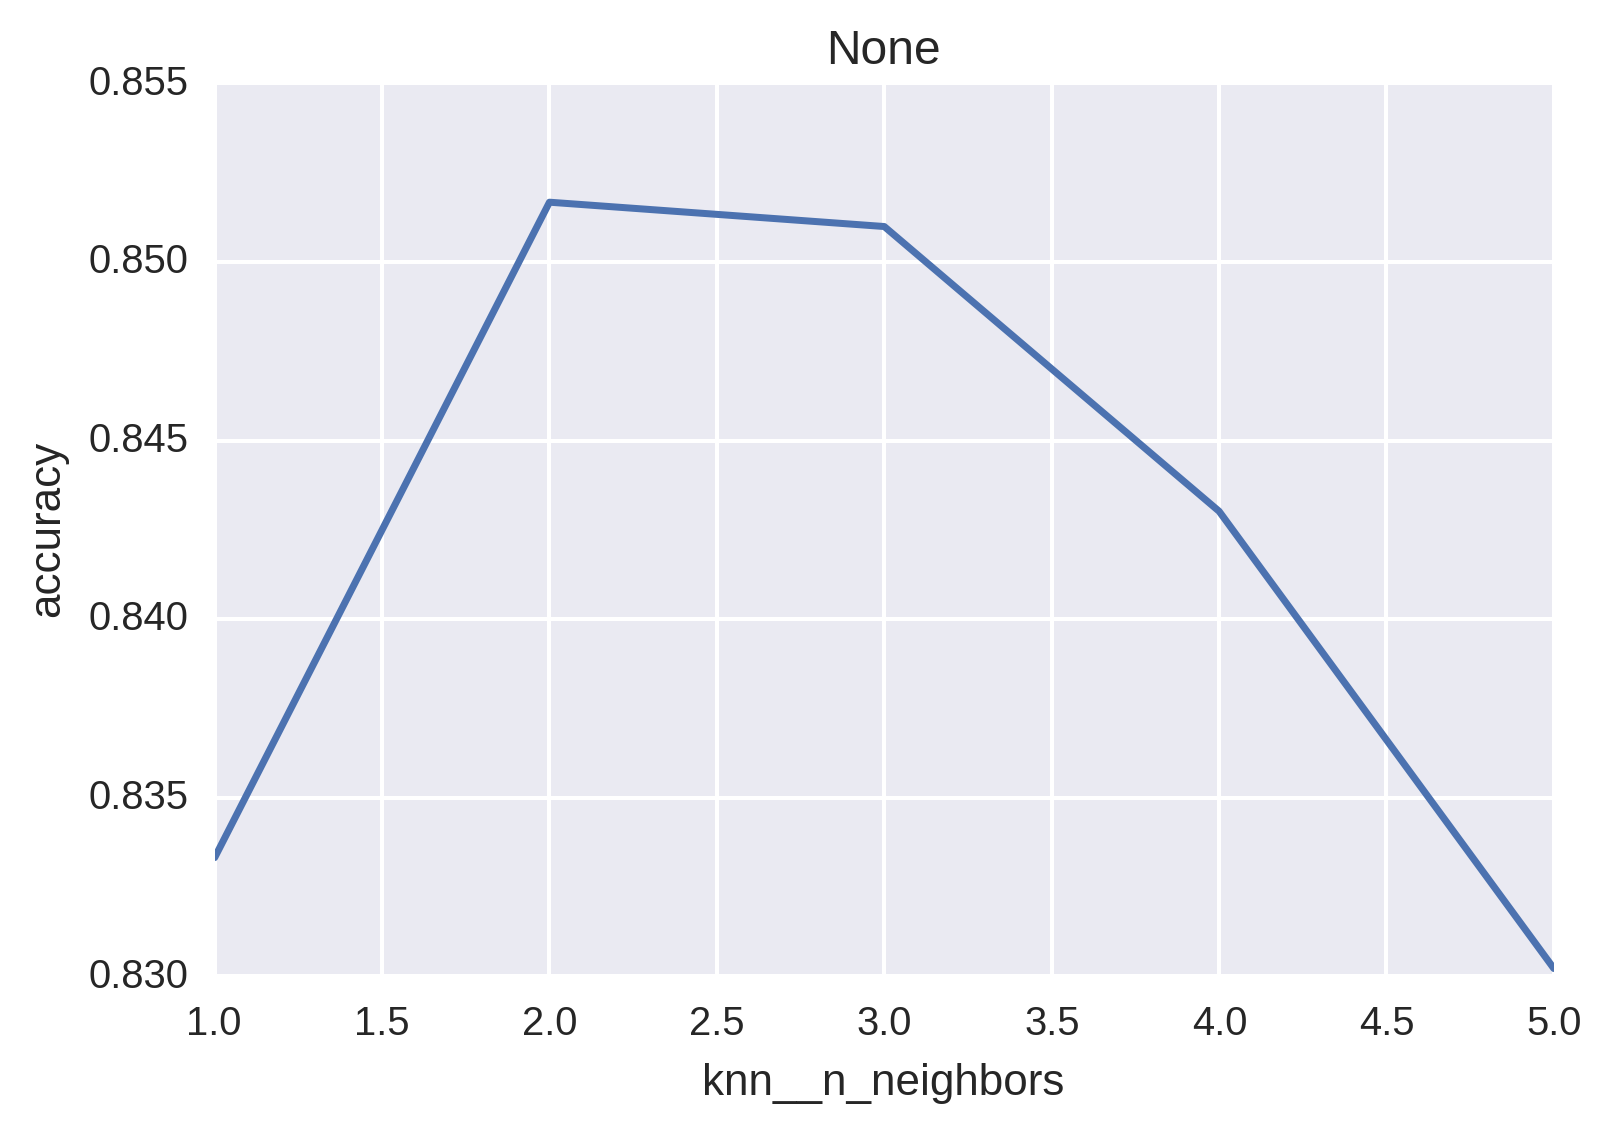

In [86]:
from sklearn import cross_validation, grid_search, neighbors
from sklearn.pipeline import Pipeline, FeatureUnion

lat_lng_pipe = Pipeline([
    ('sel',ColumnSelectTransformer(['latitude','longitude'])),
    ('knn',neighbors.KNeighborsRegressor())
  ])

param_grid = {"knn__n_neighbors": range(1,6)}
lat_lng_model = grid_search.GridSearchCV( lat_lng_pipe,
                param_grid=param_grid,
                cv=cross_validation.ShuffleSplit(len(df.index), n_iter=20, 
                    test_size=0.2, random_state=42) )

lat_lng_model.fit(X,y)

for key in param_grid.keys():
  grid_score_plotter(lat_lng_model,key)

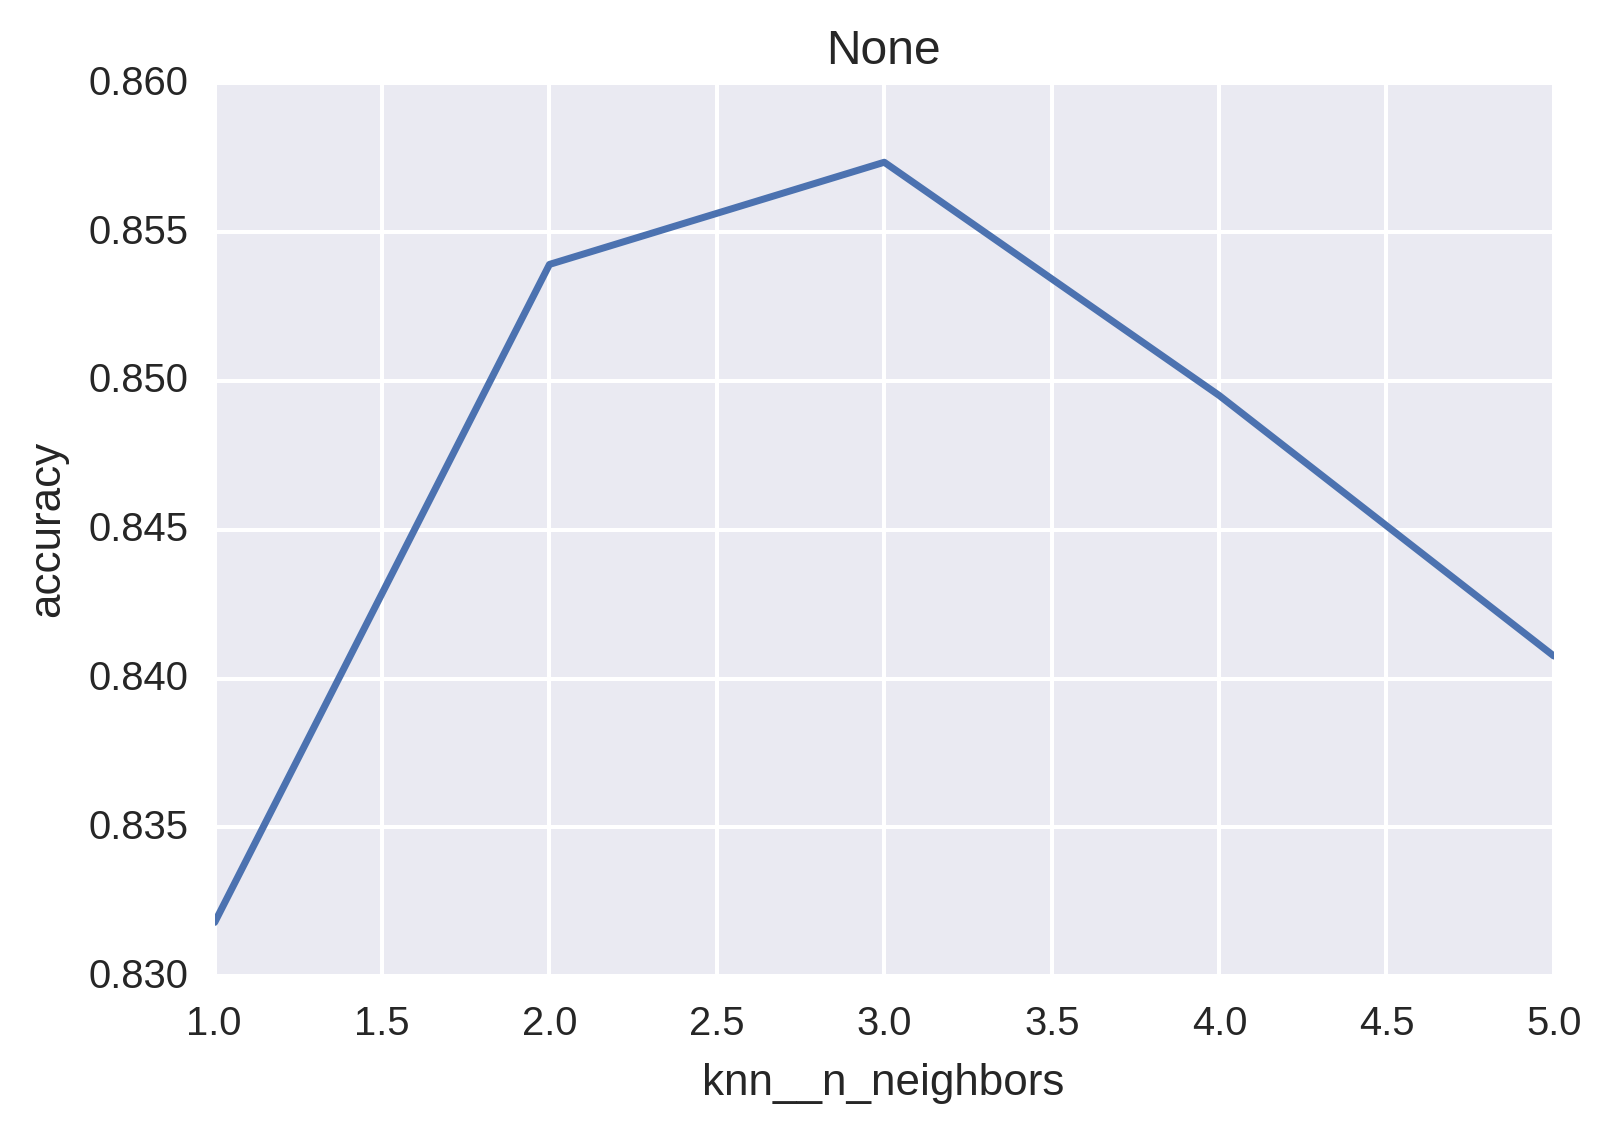

In [89]:
from sklearn import cross_validation, grid_search, neighbors
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import preprocessing

lat_lng_pipe = Pipeline([
    ('sel',ColumnSelectTransformer(['latitude','longitude'])),
    ('scaling', preprocessing.MinMaxScaler(copy=True)),
    ('knn',neighbors.KNeighborsRegressor())
  ])

param_grid = {"knn__n_neighbors": range(1,6)}
lat_lng_model = grid_search.GridSearchCV( lat_lng_pipe,
                param_grid=param_grid,
                cv=cross_validation.ShuffleSplit(len(df.index), n_iter=20, 
                    test_size=0.2, random_state=42) )

lat_lng_model.fit(X,y)

for key in param_grid.keys():
  grid_score_plotter(lat_lng_model,key)

In [91]:
computed_error = pd.DataFrame(
  {'lat_lng_err': abs(y - lat_lng_model.predict(X))
  })
computed_error.mean()

lat_lng_err    105641.588647
dtype: float64

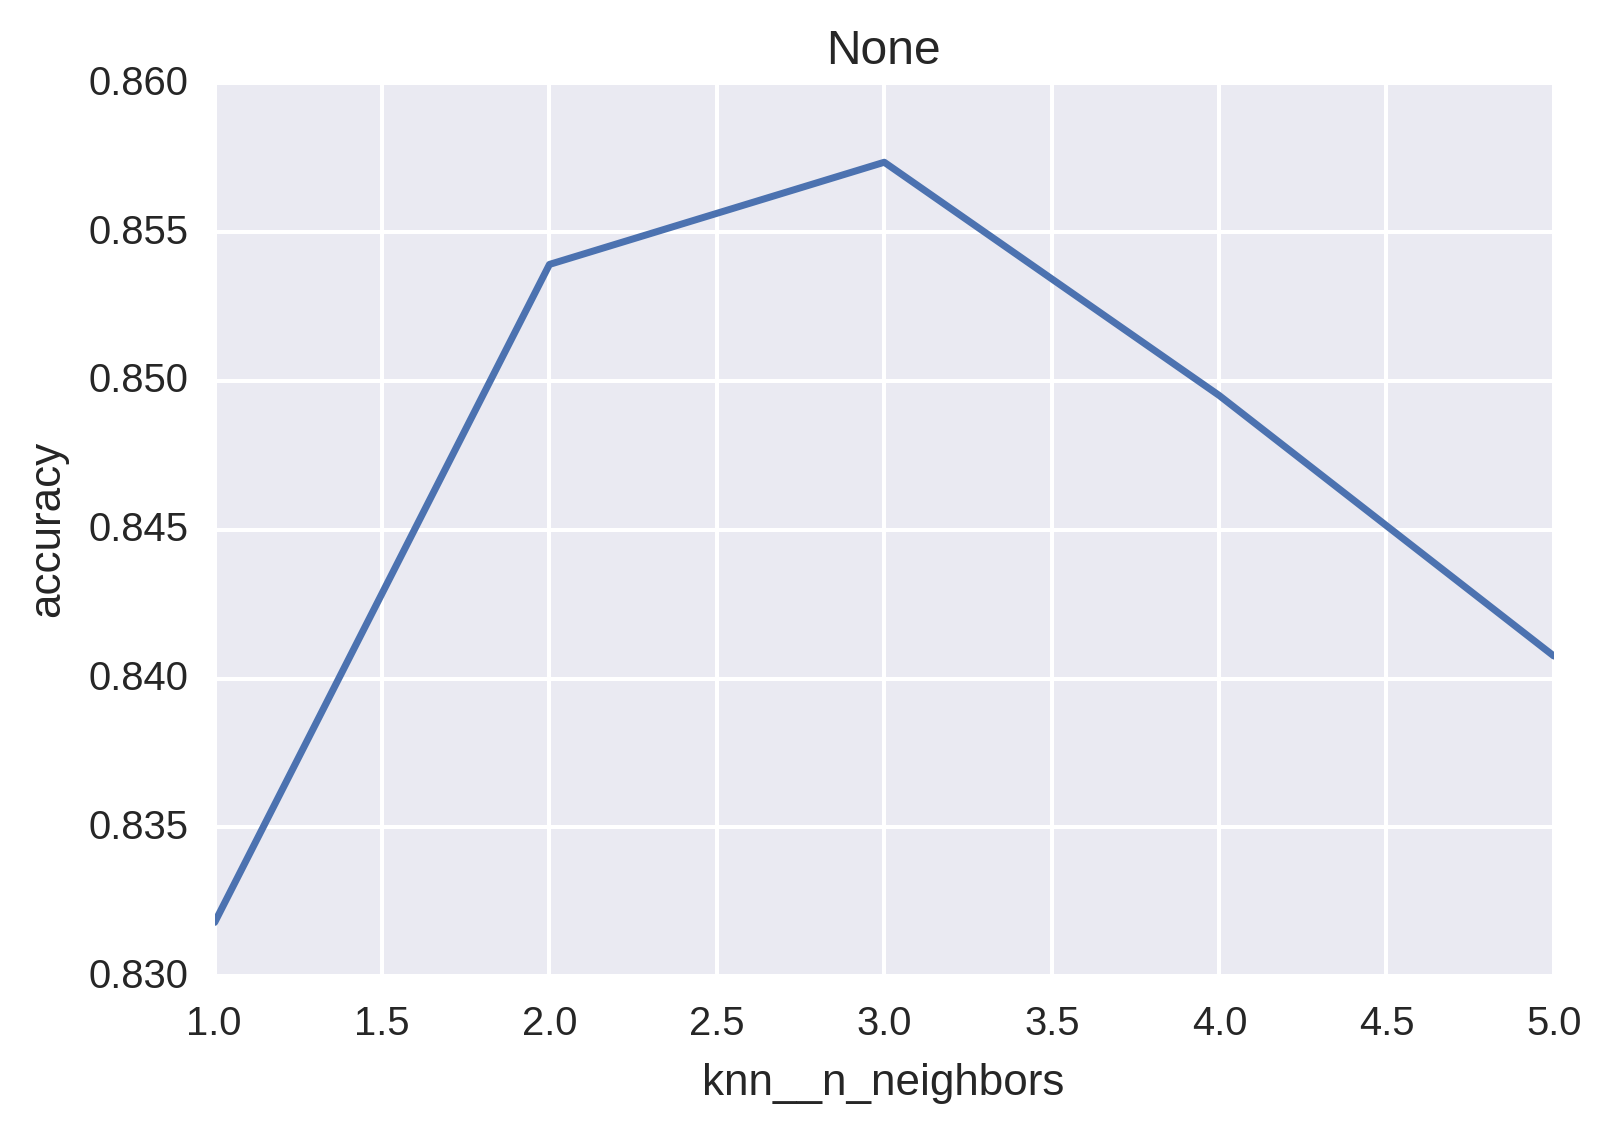

In [127]:
from sklearn import cross_validation, grid_search, neighbors
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import preprocessing

lat_lng_pipe = Pipeline([
    ('sel',ColumnSelectTransformer(['latitude','longitude'])),
    ('scaling', preprocessing.MinMaxScaler(copy=True)),
    ('knn',neighbors.KNeighborsRegressor()),
  ])

param_grid = {"knn__n_neighbors": range(1,6)}
lat_lng_model_CV = grid_search.GridSearchCV( lat_lng_pipe,
                param_grid=param_grid,
                cv=cross_validation.ShuffleSplit(len(df.index), n_iter=20, 
                    test_size=0.2, random_state=42) )

lat_lng_model_CV.fit(df,df.SALEPRICE)

for key in param_grid.keys():
  grid_score_plotter(lat_lng_model_CV,key)
  

In [131]:
lat_lng_model_CV.best_params_

{'knn__n_neighbors': 3}

In [132]:
lat_lng_model = Pipeline([
    ('sel',ColumnSelectTransformer(['latitude','longitude'])),
    ('scaling', preprocessing.MinMaxScaler(copy=True)),
    ('knn',neighbors.KNeighborsRegressor(n_neighbors=3)),
  ])
lat_lng_model.fit(df,df.SALEPRICE)
lat_lng_model.predict(df)

array([ 370500.        ,  370500.        ,  531333.33333333, ...,
        508908.33333333,  600908.33333333,  566333.33333333])

In [133]:
from sklearn import cross_validation, grid_search, neighbors
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import preprocessing

error_lat_lng_model = Pipeline([
    ('knn',ShellTransformer(lat_lng_model)),
    ('err',ErrorTransformer(df.SALEPRICE)),
  ])


np.mean(np.abs(error_lat_lng_model.transform(df)))



105641.58864738161

In [149]:
range(6,20,3)

[6, 9, 12, 15, 18]

In [155]:
from sklearn import cross_validation, grid_search, neighbors, ensemble
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn import linear_model

stats_pipe = Pipeline([
    ('sel',ColumnSelectTransformer(new_stats_cols)),
    ('scaling', preprocessing.StandardScaler(copy=True)),
    ('model',ensemble.RandomForestRegressor(min_samples_leaf=3,min_samples_split=4))
  ])

if False:
  param_grid = {"model__min_samples_split": range(2,5,2)}
  stats_model = grid_search.GridSearchCV( stats_pipe,
                  param_grid=param_grid,
                  cv=cross_validation.ShuffleSplit(len(df.index), n_iter=20, 
                      test_size=0.2, random_state=42) )

  stats_model.fit(df,df.SALEPRICE)

  for key in param_grid.keys():
    grid_score_plotter(stats_model,key)
else:
  stats_model = stats_pipe.fit(df,df.SALEPRICE)

In [169]:
## Combo RF
from sklearn import cross_validation, grid_search, neighbors, ensemble
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn import linear_model

combo_pipe = Pipeline([
    ('union',
       FeatureUnion([
              ('lat_lng_pipe',
                 Pipeline([
                  ('sel',ColumnSelectTransformer(['latitude','longitude'])),
                  ('scaling', preprocessing.MinMaxScaler(copy=True)),
                ])
              ),
              ('stats_pipe',
                 Pipeline([
                  ('sel',ColumnSelectTransformer(new_stats_cols)),
                  ('scaling', preprocessing.StandardScaler(copy=True)),
                ])
              ),          
      ]) 
    ),  
    ('model',ensemble.RandomForestRegressor(min_samples_leaf=2,min_samples_split=2))
  ])

if 0:
  param_grid = {"model__min_samples_split": range(1,3),"model__min_samples_leaf": range(1,4)}
  combo_model = grid_search.GridSearchCV( combo_pipe,
                  param_grid=param_grid,
                  cv=cross_validation.ShuffleSplit(len(df.index), n_iter=20, 
                      test_size=0.2, random_state=42) )

  combo_model.fit(df,df.SALEPRICE)

  for key in param_grid.keys():
    grid_score_plotter(combo_model,key)
else:
  combo_model = combo_pipe.fit(df,df.SALEPRICE)

In [171]:
np.mean(np.abs(combo_model.predict(df) - df.SALEPRICE))

85536.956668485407

In [174]:
if 1:
  with open('./data/p_combo_model_rf.dpkl','wb') as p_output:
    pickle.dump(combo_model,p_output)

In [163]:
neighbors.KNeighborsRegressor?

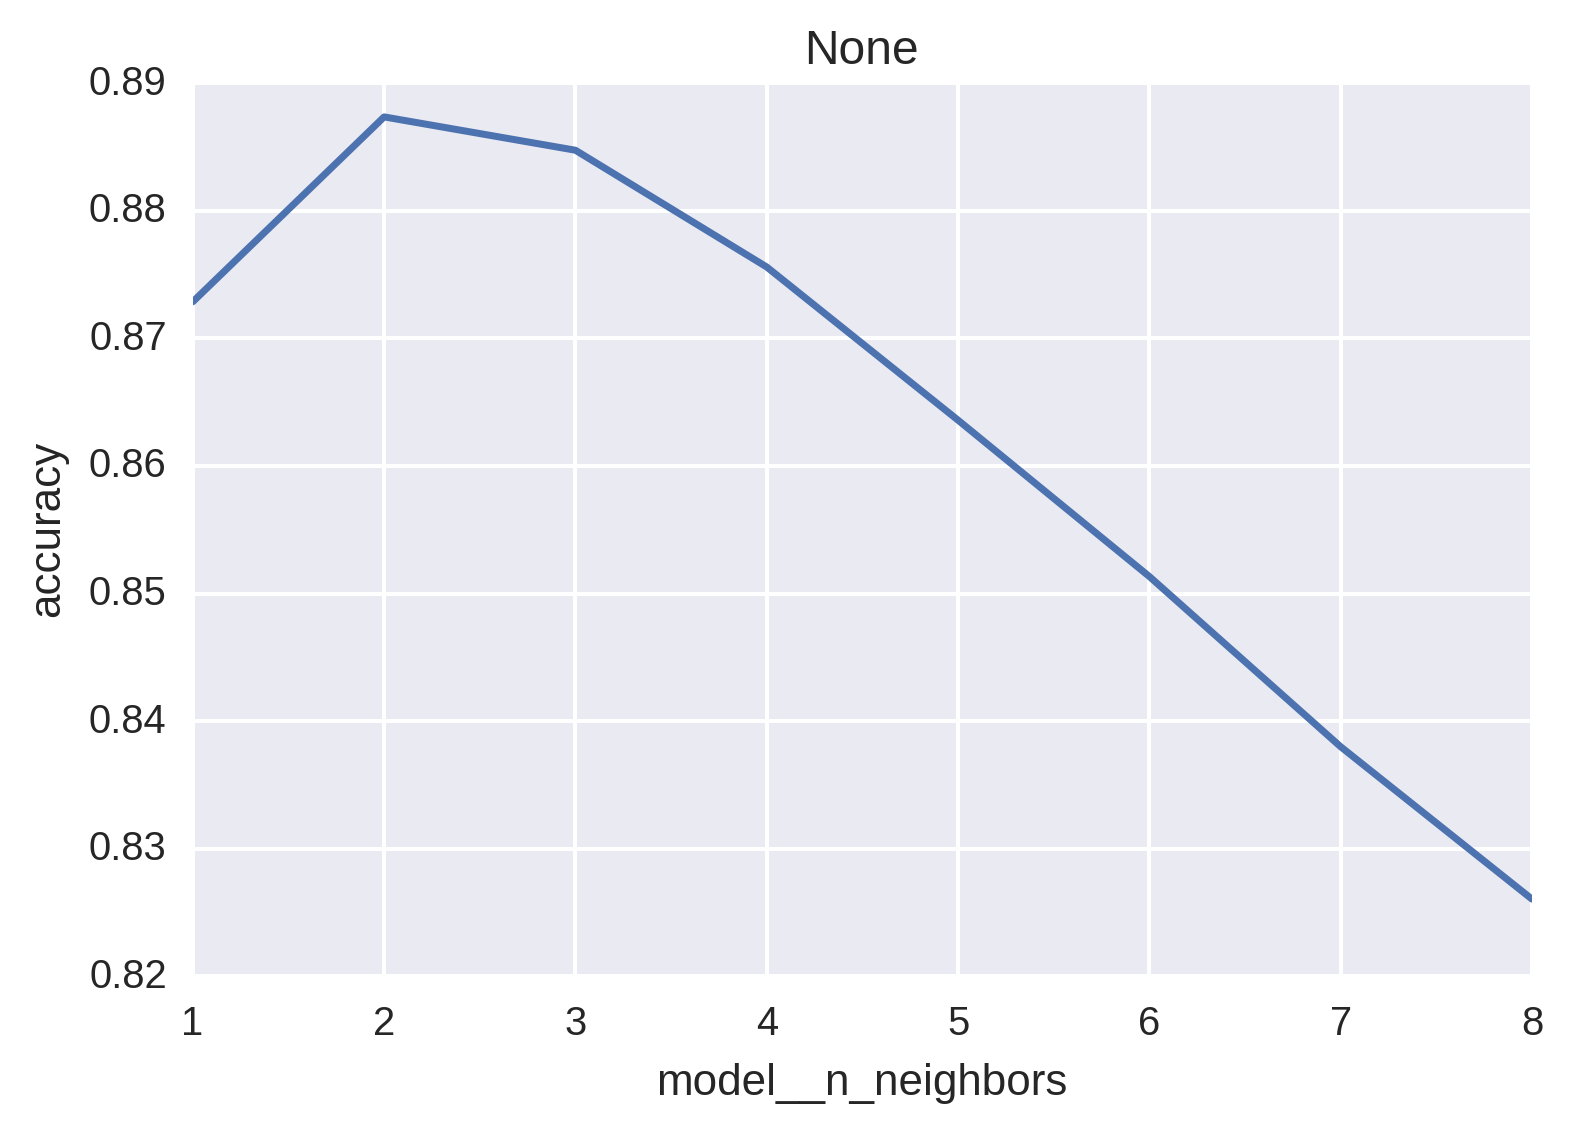

In [168]:
## Combo KNN
from sklearn import cross_validation, grid_search, neighbors, ensemble
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn import linear_model

combo_pipe = Pipeline([
    ('union',
       FeatureUnion([
              ('landarea_pipe',
                 Pipeline([
                  ('sel',ColumnSelectTransformer(['LANDAREA'])),
                  ('scaling', preprocessing.StandardScaler(copy=True)),
                ])
              ),
              ('lat_lng_pipe',
                 Pipeline([
                  ('sel',ColumnSelectTransformer(['latitude','longitude'])),
                  ('scaling', preprocessing.MinMaxScaler(copy=True)),
                ])
              ),
              ('stats_pipe',
                 Pipeline([
                  ('sel',ColumnSelectTransformer(new_stats_cols)),
                  ('scaling', preprocessing.StandardScaler(copy=True)),
                ])
              ),          
      ]) 
    ),  
    ('model',neighbors.KNeighborsRegressor())
  ])

if 1:
  param_grid = {"model__n_neighbors": range(1,9)}
  combo_model = grid_search.GridSearchCV( combo_pipe,
                  param_grid=param_grid,
                  cv=cross_validation.ShuffleSplit(len(df.index), n_iter=20, 
                      test_size=0.2, random_state=42) )

  combo_model.fit(df,df.SALEPRICE)

  for key in param_grid.keys():
    grid_score_plotter(combo_model,key)
else:
  combo_model = combo_pipe.fit(df,df.SALEPRICE)

In [104]:
np.mean(np.abs(X.SALEPRICE-full_pipe.predict(X)))


106588.6758087496